In [ ]:
#Student_name: Haoyang Guo
#Student_ID: A0295733U
#Course: MLE 5243

In [ ]:
# To build a smart tool to predict bandgap, we need to split this task into these steps:
# Firstly, we need to pre process the data, see if there is any data missing or not.
# Secondly, we need to set the feature generater and do feature engineering
# Thirdly, we need to normalize the data, split the data into training and testing sets, then train the model
# Fourthly, we need to evaluate the model and see if it is good enough to be used in real life.

In [1]:
# --- IMPORT NECESSARY LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




In [ ]:
%pip install matminer pymatgen pandas

from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

# --- Load and Preprocess data ---
# Read in the dataset
df = pd.read_csv('Bandgap_data.csv')

# Rename column for clarity
df = df.rename(columns={"Eg (eV)": "band_gap"})

# Ensure the 'composition' column is valid
df['composition'] = df['composition'].apply(lambda x: Composition(x) if pd.notnull(x) else None)

# --- FEATURIZE THE DATASET ---
# Initialize the featurizer
ep = ElementProperty.from_preset("magpie")

# Featurize the dataset, ignoring errors
df = ep.featurize_dataframe(df, col_id="composition", ignore_errors=True)

# Display the first few rows of the featurized dataset
print(df.head())

Note: you may need to restart the kernel to use updated packages.


d:\miniconda\envs\mi\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/3896 [00:00<?, ?it/s]

    composition  band_gap  MagpieData minimum Number  \
0  (Hg, Cd, Te)      0.35                       48.0   
1      (Cu, Br)      3.08                       29.0   
2       (Lu, P)      1.30                       15.0   
3  (Cu, Sb, Se)      0.40                       29.0   
4       (Zn, O)      3.44                        8.0   

   MagpieData maximum Number  MagpieData range Number  MagpieData mean Number  \
0                       80.0                     32.0                   61.20   
1                       35.0                      6.0                   32.00   
2                       71.0                     56.0                   43.00   
3                       51.0                     22.0                   34.25   
4                       30.0                     22.0                   19.00   

   MagpieData avg_dev Number  MagpieData mode Number  \
0                    13.1600                    52.0   
1                     3.0000                    29.0   
2       

In [ ]:
# Normalize the data and split into training and testing sets

# X = all generated features (excluding raw composition info)
X = df[ep.feature_labels()]
y = df['band_gap']

# Debug: Check for missing values
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

# Handle missing values
X = X.dropna()
y = y[X.index]  # Ensure alignment between X and y

# Standardize features using sklearn's StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Debug: Check tensor shapes
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

Missing values in X: 132
Missing values in y: 0
X_train_tensor shape: torch.Size([3116, 132])
y_train_tensor shape: torch.Size([3116, 1])
X_test_tensor shape: torch.Size([779, 132])
y_test_tensor shape: torch.Size([779, 1])


In [ ]:

# --- DEFINE A NEURAL NETWORK MODEL ---
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),   # First hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),           # Second hidden layer
            nn.ReLU(),
            nn.Linear(32, 1)             # Output layer (regression)
        )

    def forward(self, x):
        return self.model(x)
    
# Here I build a MLP model to predict the bandgap.
# I chose to use 2 hidden layers, the first one has 64 neurons and the second one has 32 neurons.
# The output layer has 1 neuron because we are doing regression.
# The ReLU activation function is used for the hidden layers to introduce non-linearity.

In [ ]:
# --- TRAIN THE MODEL ---
# Initialize the model
input_size = X_train_tensor.shape[1]  # Number of input features
model = MLP(input_size)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 150
for epoch in range(epochs):
    model.train()  # Set model to training mode

    y_pred = model(X_train_tensor)             # Forward pass
    loss = loss_fn(y_pred, y_train_tensor)     # Compute loss

    optimizer.zero_grad()                      # Reset gradients
    loss.backward()                            # Backpropagation
    optimizer.step()                           # Update weights

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}")

Epoch 0, Training Loss: 6.6747
Epoch 10, Training Loss: 4.3713
Epoch 20, Training Loss: 1.6736
Epoch 30, Training Loss: 1.1369
Epoch 40, Training Loss: 0.7337
Epoch 50, Training Loss: 0.6588
Epoch 60, Training Loss: 0.5707
Epoch 70, Training Loss: 0.5266
Epoch 80, Training Loss: 0.4955
Epoch 90, Training Loss: 0.4708
Epoch 100, Training Loss: 0.4507
Epoch 110, Training Loss: 0.4332
Epoch 120, Training Loss: 0.4174
Epoch 130, Training Loss: 0.4029
Epoch 140, Training Loss: 0.3895


In [ ]:

# --- EVALUATE ON TEST SET ---
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()
    actuals = y_test_tensor.squeeze().numpy()

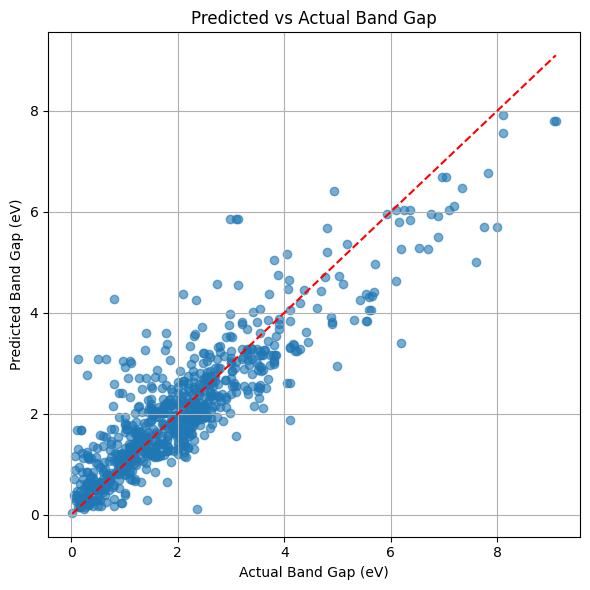

In [ ]:
# Visulization of the results
plt.figure(figsize=(6, 6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
plt.xlabel("Actual Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Predicted vs Actual Band Gap")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# CALCULATE ERROR METRICS 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Debug: Print actuals and predictions
print("Actuals:", actuals)
print("Predictions:", predictions)

# Ensure predictions and actuals are not empty
if actuals.size == 0 or predictions.size == 0:
    print("Error: Predictions or actuals are empty. Ensure the model is trained and predictions are generated correctly.")
else:
    # Check for NaN values
    print("NaN in actuals:", np.isnan(actuals).any())
    print("NaN in predictions:", np.isnan(predictions).any())

    # Handle NaN values (remove rows with NaN)
    valid_indices = ~np.isnan(actuals) & ~np.isnan(predictions)
    actuals = actuals[valid_indices]
    predictions = predictions[valid_indices]

    # Ensure valid_indices is not empty
    if actuals.size == 0 or predictions.size == 0:
        print("Error: No valid data points after removing NaN values.")
    else:
        # Calculate error metrics
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        print(f"RMSE: {rmse:.4f} eV")
        print(f"MAE:  {mae:.4f} eV")

Actuals: [2.98 2.64 1.8  1.13 1.   4.17 1.76 0.85 5.7  0.45 1.09 1.08 0.98 1.19
 0.11 2.3  3.82 1.46 3.73 6.15 2.23 2.   1.44 2.76 1.45 2.46 1.5  1.65
 0.48 2.6  0.5  2.59 5.1  2.2  1.87 2.3  3.1  1.33 1.04 1.45 1.51 1.
 3.52 0.46 0.17 1.72 2.5  1.   3.24 4.1  2.47 2.2  2.   2.54 2.12 0.9
 1.07 8.1  2.37 4.2  1.05 3.64 2.5  1.5  2.   2.98 2.2  2.2  0.3  1.2
 1.65 3.5  3.7  0.4  1.8  2.21 1.61 0.12 2.32 3.5  1.87 0.08 1.   1.85
 1.1  1.2  2.5  0.96 1.84 0.91 2.3  0.55 5.93 1.74 2.3  0.68 2.   1.62
 0.3  0.72 2.54 2.53 3.1  0.46 4.07 1.6  1.39 1.89 0.28 1.4  2.46 1.38
 3.66 1.61 0.37 2.53 2.04 3.9  3.8  1.93 0.54 1.08 1.15 1.27 1.11 0.8
 2.41 2.13 0.14 2.37 1.47 6.53 0.7  3.25 2.29 3.85 1.8  5.56 6.97 2.4
 1.26 3.02 1.87 3.4  1.59 4.9  1.77 3.3  6.89 1.9  0.95 2.32 4.87 3.6
 2.58 2.1  0.12 3.54 9.1  2.25 2.83 0.74 1.45 5.69 2.   1.   2.75 2.53
 0.3  2.06 2.49 0.8  0.54 3.2  1.8  1.4  0.52 3.9  2.49 0.07 2.3  2.6
 3.02 0.9  2.4  1.28 1.33 2.09 4.24 1.75 1.19 0.43 4.1  2.   0.78 3.02
 2.68

In [ ]:
# The rather low RMSE and MAE values indicate that the model is performing well on the test set.
# This suggests that the model is capable of accurately predicting bandgap values based on the provided features.

In [ ]:
# Here I compare different featurizers to see which one is better.
# This might help us to find a better way to predict the bandgap.

# --- COMPARE DIFFERENT FEATURIZERS ---
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

# --- STEP 1: DATA LOADING & PREPROCESSING ---
def load_and_preprocess_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    print(f"Data loaded. Shape: {df.shape}")
    
    # Rename columns
    if "Eg (eV)" in df.columns:
        df = df.rename(columns={"Eg (eV)": "band_gap"})
    else:
        raise ValueError("Column 'Eg (eV)' not found in the dataset.")
    
    # Validate composition
    def is_valid_composition(formula):
        try:
            Composition(formula)
            return True
        except Exception:
            return False

    df['composition'] = df['composition'].apply(
        lambda x: Composition(x) if pd.notnull(x) and is_valid_composition(x) else None
    )
    df = df.dropna(subset=['composition'])
    print(f"Filtered invalid compositions. Remaining: {len(df)}")
    
    # Filter band_gap values
    df = df[(df['band_gap'] >= 0) & (df['band_gap'] <= 10)]
    print(f"Data size after band_gap filtering: {len(df)}")
    
    return df

# Load the data
df = load_and_preprocess_data("Bandgap_data.csv")

# --- STEP 2: DEFINE A FUNCTION TO TRAIN AND EVALUATE THE MODEL ---
def train_and_evaluate(df, featurizer_name):
    print(f"\n--- Using Featurizer: {featurizer_name} ---")
    
    # Initialize the featurizer
    ep = ElementProperty.from_preset(featurizer_name)
    
    # Featurize the dataset
    df = ep.featurize_dataframe(df, col_id="composition", ignore_errors=True)
    
    # Drop rows with missing features
    df = df.dropna()
    
    # Extract features (X) and target (y)
    X = df[ep.feature_labels()]
    y = df['band_gap']
    
    # Feature selection
    selector = SelectKBest(score_func=f_regression, k=50)  # Select top 50 features
    X_selected = selector.fit_transform(X, y)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    
    # Define the model
    class MLP(nn.Module):
        def __init__(self, input_size):
            super(MLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 1)
            )
        def forward(self, x):
            return self.model(x)
    
    # Initialize the model
    input_size = X_train_tensor.shape[1]
    model = MLP(input_size)
    
    # Define the loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=False)
    
    # Training loop
    epochs = 150
    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
        actuals = y_test_tensor.squeeze().numpy()
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        print(f"RMSE: {rmse:.4f} eV")
        print(f"MAE:  {mae:.4f} eV")
        print(f"R²:   {r2:.4f}")
        
        # Return metrics
        return rmse, mae, r2

# --- STEP 3: COMPARE DIFFERENT FEATURIZERS ---
# Update the featurizers list with valid preset names for ElementProperty
featurizers = ['magpie', 'deml', 'matminer']  
results = {}

for featurizer in featurizers:
    results[featurizer] = train_and_evaluate(df.copy(), featurizer)

# --- STEP 4: DISPLAY RESULTS ---
print("\n--- Comparison of Featurizers ---")
for featurizer, (rmse, mae, r2) in results.items():
    print(f"{featurizer}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

Data loaded. Shape: (3896, 2)
Filtered invalid compositions. Remaining: 3896
Data size after band_gap filtering: 3890

--- Using Featurizer: magpie ---


d:\anaconda3\envs\mi\lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/3890 [00:00<?, ?it/s]

d:\anaconda3\envs\mi\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RMSE: 0.7974 eV
MAE:  0.5760 eV
R²:   0.7253

--- Using Featurizer: deml ---


d:\anaconda3\envs\mi\lib\site-packages\matminer\utils\data.py:218: UserWarning: DemlData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/3890 [00:00<?, ?it/s]

d:\anaconda3\envs\mi\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RMSE: 0.5957 eV
MAE:  0.4174 eV
R²:   0.8087

--- Using Featurizer: matminer ---


ElementProperty:   0%|          | 0/3890 [00:00<?, ?it/s]

d:\anaconda3\envs\mi\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RMSE: 0.5411 eV
MAE:  0.2774 eV
R²:   0.6486

--- Comparison of Featurizers ---
magpie: RMSE = 0.7974, MAE = 0.5760, R² = 0.7253
deml: RMSE = 0.5957, MAE = 0.4174, R² = 0.8087
matminer: RMSE = 0.5411, MAE = 0.2774, R² = 0.6486


In [ ]:
# The results show that deml featurizer is the best one among these three, reaching a R² of 0.8087.

In [ ]:
# I asked ChatGPT to evaluate the whole process and give me some suggestions.
# Here is the evaluation:
# Advantages: Clear task decomposition; Appropriate tools used; Comprehensive data preprocessing; 
              # Reasonable model design; Training process visualization and error handling.
# Disadvantages: #Feature engineering could be improved; Model complexity could be increased:
                 # Training process could be improved; Optimizer and learning rate adjustment could be added; 
                 # Data distribution issues; Model evaluation could be improved; Code optimization needed; 
                 # Data augmentation could be considered.
# Suggestions:  # 1. Explore more advanced feature engineering techniques;
                # 2. Experiment with more complex models (e.g., deeper networks, ensemble methods);
                # 3. Implement early stopping and learning rate scheduling;
                # 4. Analyze data distribution and consider transformations;
                # 5. Use cross-validation for more robust evaluation metrics;
                # 6. Optimize code for better performance and readability;
                # 7. Consider data augmentation techniques to improve model robustness.
                # 8. Document the code and add comments for better understanding.
                # 9. Consider using a validation set to tune hyperparameters.
                # 10. Explore transfer learning or pre-trained models if applicable.

In [ ]:
# We can further improve the model by tuning hyperparameters, using more advanced architectures, or using ensemble methods.
# I present the code to improve hyperparameters in next cell but not run it here.

In [ ]:
# --- HYPERPARAMETER TUNING ---
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
import numpy as np

# Define the cross-validation strategy (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with scaling and classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=kf, scoring='accuracy')

# Print the cross-validation scores and statistics
print("Cross-validation scores for each fold:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))
print("Standard deviation of cross-validation accuracy:", np.std(cv_scores))
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

from sklearn.model_selection import GridSearchCV
# Initialize Grid Search
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
# Best estimator
best_svc = grid_search.best_estimator_

# Make predictions
y_pred_best = best_svc.predict(X_test_scaled)

# Calculate accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy after Hyperparameter Tuning: {accuracy_best:.2f}")

# Classification report
print("\nClassification Report After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, cmap='Greens', fmt='d',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Hyperparameter Tuning')
plt.show()


In [ ]:
# Beside this job, I thought about fetch more data regarding electronegativity, ionization energy, valence electron count and other factors related to bandgap energy
# I tried fetch these data from Materials Project and train models like GNN and GAN.
# I asked co-pilot to generate a project to realize this function. 
# However, I tried to run it on my laptop, but it didn't go through successfully. This might be due the lack of calculation power of my laptop.
# I upload the code on https://github.com/haoyang027/5243-Assignment2，you can check it if you are interested.